##### Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from utils import *

# Atlas Data

International Trade Data (HS, 12) Years 2012 - 2022

In [3]:
df = pd.concat([pd.read_stata(f"{data_paths['atlas']}/hs12_country_country_product_year_4_2012_2016.dta"),
                pd.read_stata(f"{data_paths['atlas']}/hs12_country_country_product_year_4_2017_2021.dta"),
                pd.read_stata(f"{data_paths['atlas']}/hs12_country_country_product_year_4_2022.dta")])
products = pd.read_csv(f"{data_paths['atlas']}/product_hs12.csv")
countries = pd.read_csv(f"{data_paths['atlas']}/location_country.csv")

##### Check for discrepancies between countries Import/Exports

In [4]:
for year in range(2012, 2023):
    _ = df.loc[df.year == year, ["country_id", "partner_country_id", "export_value", "import_value"]]
    _ = _.groupby(["country_id", "partner_country_id"]).sum().reset_index()
    _ = _.merge(_, left_on=["country_id", "partner_country_id"], right_on=["partner_country_id", "country_id"], how="outer")
    _["discrepancy"] = abs(_["export_value_x"] - _["import_value_y"]) + abs(_["export_value_y"] - _["import_value_x"])
    print(year, _.discrepancy.sum())

2012 0.0
2013 0.0
2014 0.0
2015 0.0
2016 0.0
2017 0.0
2018 0.0
2019 0.0
2020 0.0
2021 0.0
2022 0.0


### Yearly Exports/Imports trend 

In [5]:
yearly = df[["year", "export_value", "import_value"]].groupby("year").agg(Links=("year", "count"), Exports=("export_value", "sum"), Imports=("import_value", "sum")).reset_index()
yearly.head()

,year,Links,Exports,Imports
0,2012,4725710,1.756753e+13,1.756753e+13
1,2013,5107794,1.808927e+13,1.808927e+13
2,2014,5302746,1.804646e+13,1.804646e+13
3,2015,5427378,1.556721e+13,1.556721e+13
4,2016,5470412,1.514018e+13,1.514018e+13


''

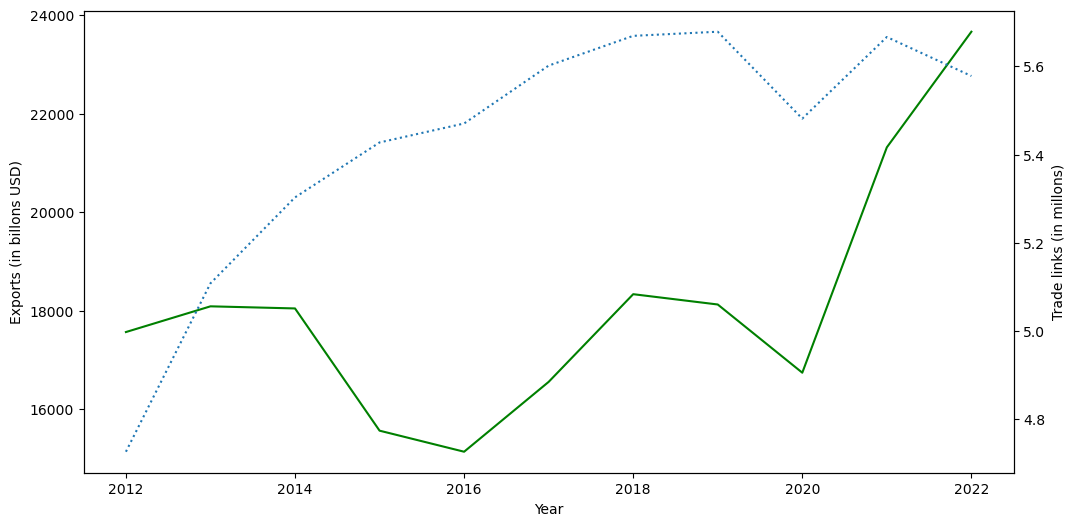

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
ax2 = plt.twinx()
sns.lineplot(x=yearly.year, y=yearly.Exports/1e9, color="green", ax=ax)
sns.lineplot(x=yearly.year, y=yearly.Links/1e6, linestyle=":", ax=ax2)
ax.set_ylabel("Exports (in billons USD)")
ax2.set_ylabel("Trade links (in millons)")
ax.set_xlabel("Year")
;

NOTE: Fluctuations might be due to quantity or price.

### Countries that export and import same category of products

In [7]:
df[["country_id", "product_id", "export_value", "import_value"]].groupby(["country_id", "product_id"]).sum().reset_index()

,country_id,product_id,export_value,import_value
0,4,650,2.850600e+04,2.632367e+07
1,4,651,3.421209e+06,2.497327e+07
2,4,652,0.000000e+00,9.429200e+04
3,4,653,4.564594e+06,4.845600e+05
4,4,654,0.000000e+00,8.145161e+07
...,...,...,...,...
263775,999,1870,1.759357e+08,8.823878e+06
263776,999,1871,2.012647e+06,9.283320e+05
263777,999,1872,1.603584e+08,1.182924e+07
263778,999,1873,8.734514e+07,1.280178e+06


### Countries trading balance

In [8]:
trading_balance = df[["country_id", "export_value", "import_value"]].groupby("country_id").sum().reset_index()
trading_balance["balance"] = trading_balance.export_value - trading_balance.import_value
trading_balance = trading_balance.sort_values("balance")
trading_balance.merge(countries[["country_id", "name_short_en"]], on="country_id", how="left")

,country_id,export_value,import_value,balance,name_short_en
0,840,1.732388e+13,2.520519e+13,-7.881306e+12,United States of America
1,344,1.683100e+12,7.189115e+12,-5.506015e+12,Hong Kong
2,999,1.723835e+12,5.478672e+12,-3.754837e+12,Undeclared
3,826,4.960173e+12,6.876737e+12,-1.916564e+12,United Kingdom
4,356,3.319970e+12,4.515305e+12,-1.195334e+12,India
...,...,...,...,...,...
231,784,3.874210e+12,2.798211e+12,1.075999e+12,United Arab Emirates
232,682,3.202120e+12,1.610575e+12,1.591545e+12,Saudi Arabia
233,643,4.669754e+12,2.592844e+12,2.076910e+12,Russia
234,276,1.538378e+13,1.242025e+13,2.963531e+12,Germany


### PCI

In [9]:
products_complexity_volume = df[["product_id", "export_value", "pci"]].groupby("product_id").agg({"export_value": "sum", "pci": "mean"}).reset_index()

In [10]:
scaler = StandardScaler()

In [11]:
products_complexity_volume["volume"] = scaler.fit_transform(products_complexity_volume["export_value"].values.reshape(-1,1))

In [12]:
products_complexity_volume.describe()

,product_id,export_value,pci,volume
count,1226.000000,1.226000e+03,1226.000000,1.226000e+03
mean,1262.500000,1.624351e+11,0.000123,-1.448904e-17
std,354.060023,6.408137e+11,0.972519,1.000408e+00
min,650.000000,5.170973e+07,-2.808303,-2.535053e-01
25%,956.250000,1.013899e+10,-0.661058,-2.377576e-01
50%,1262.500000,3.538830e+10,0.091042,-1.983395e-01
75%,1568.750000,1.133135e+11,0.771200,-7.668632e-02
max,1875.000000,1.227404e+13,2.284898,1.890807e+01


Let's visualize PCI of products vs Export Volume

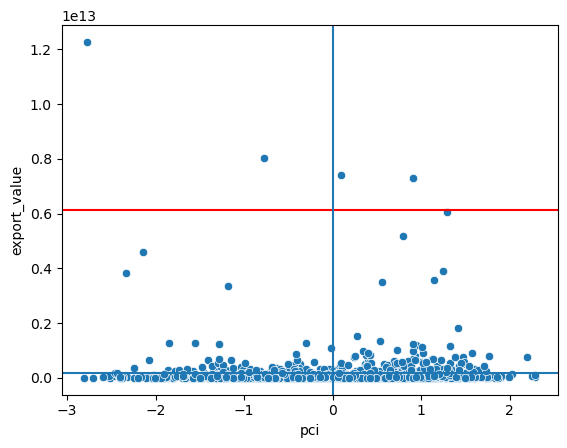

In [13]:
ax = sns.scatterplot(x=products_complexity_volume.pci, y=products_complexity_volume.export_value)
ax.axhline(products_complexity_volume.export_value.mean())
ax.axhline((products_complexity_volume.export_value.max()-products_complexity_volume.export_value.min())/2, color="red")
ax.axvline(products_complexity_volume.pci.mean())

### In theory, PCI is correlated to the number of countries that export a given product

In [14]:
df.head()

,country_id,partner_country_id,year,product_id,export_value,import_value,coi,eci,pci
0,4,12,2014,716,24283.0,0.0,-0.753242,-0.770857,-1.136563
1,4,36,2014,716,1080066.0,0.0,-0.753242,-0.770857,-1.136563
2,4,48,2014,716,16698.0,0.0,-0.753242,-0.770857,-1.136563
3,4,56,2014,716,77203.0,0.0,-0.753242,-0.770857,-1.136563
4,4,76,2014,716,668840.0,0.0,-0.753242,-0.770857,-1.136563


In [15]:
most_complex_products = products_complexity_volume.sort_values("pci", ascending=False)[:10]
most_complex_products_countries = most_complex_products.merge(df[["country_id", "product_id"]], on="product_id", how="inner")
most_complex_products_countries = most_complex_products_countries.merge(countries[["country_id", "name_short_en"]], on="country_id", how="left").merge(products[["product_id", "name_short_en"]], on="product_id", how="left")
most_complex_products_countries

,product_id,export_value,pci,volume,country_id,name_short_en_x,name_short_en_y
0,1663,1.116085e+11,2.284898,-0.079348,4,Afghanistan,Machining centers for working metal
1,1663,1.116085e+11,2.284898,-0.079348,8,Albania,Machining centers for working metal
2,1663,1.116085e+11,2.284898,-0.079348,8,Albania,Machining centers for working metal
3,1663,1.116085e+11,2.284898,-0.079348,8,Albania,Machining centers for working metal
4,1663,1.116085e+11,2.284898,-0.079348,12,Algeria,Machining centers for working metal
...,...,...,...,...,...,...,...
322513,1681,5.111178e+10,1.852888,-0.173793,999,Undeclared,Machines for assembling electric lamps
322514,1681,5.111178e+10,1.852888,-0.173793,999,Undeclared,Machines for assembling electric lamps
322515,1681,5.111178e+10,1.852888,-0.173793,999,Undeclared,Machines for assembling electric lamps
322516,1681,5.111178e+10,1.852888,-0.173793,999,Undeclared,Machines for assembling electric lamps
